
[Problem 1] Execution of machine translation and code reading

In [52]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2021-06-23 18:25:46--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 2606:4700:3036::ac43:adc6, 2606:4700:3031::6815:37de, 104.21.55.222, ...
Connecting to www.manythings.org (www.manythings.org)|2606:4700:3036::ac43:adc6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6444324 (6.1M) [application/zip]
Saving to: 'fra-eng.zip'

     0K .......... .......... .......... .......... ..........  0% 93.6K 67s
    50K .......... .......... .......... .......... ..........  1%  188K 50s
   100K .......... .......... .......... .......... ..........  2% 1.54M 34s
   150K .......... .......... .......... .......... ..........  3% 1.54M 26s
   200K .......... .......... .......... .......... ..........  3%  238K 26s
   250K .......... .......... .......... .......... ..........  4% 3.90M 22s
   300K .......... .......... .......... .......... ..........  5%  951K 19s
   350K .......... .......... .......... .......... ...

In [53]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 70s 478ms/step - loss: 1.4646 - accuracy: 0.7057 - val_loss: 1.0162 - val_accuracy: 0.7236
Epoch 2/100
125/125 [==============================] - 35s 281ms/step - loss: 0.8632 - accuracy: 0.7677 - val_loss: 0.8361 - val_accuracy: 0.7653
Epoch 3/100
125/125 [==============================] - 25s 204ms/step - loss: 0.6837 - accuracy: 0.8111 - val_loss: 0.7174 - val_accuracy: 0.7951
Epoch 4/100
125/125 [==============================] - 27s 213ms/step - loss: 0.5954 - accuracy: 0.8272 - val_loss: 0.6346 - val_accuracy: 0.8144
Epoch 5/100
125/125 [==============================] - 25s 198ms/step - loss: 0.5367 - accuracy: 0.8430 - val_loss: 0.5944 - val_accuracy: 0.8283
Epoch 6/100
125/125 [==============================] - 25s 200ms/step - loss: 0.5012 - accuracy: 0.8530 -

125/125 [==============================] - 25s 202ms/step - loss: 0.0953 - accuracy: 0.9702 - val_loss: 0.5820 - val_accuracy: 0.8733
Epoch 56/100
125/125 [==============================] - 25s 200ms/step - loss: 0.0943 - accuracy: 0.9707 - val_loss: 0.5875 - val_accuracy: 0.8738
Epoch 57/100
125/125 [==============================] - 24s 190ms/step - loss: 0.0921 - accuracy: 0.9711 - val_loss: 0.5906 - val_accuracy: 0.8729
Epoch 58/100
125/125 [==============================] - 21s 172ms/step - loss: 0.0898 - accuracy: 0.9721 - val_loss: 0.5910 - val_accuracy: 0.8732
Epoch 59/100
125/125 [==============================] - 24s 195ms/step - loss: 0.0874 - accuracy: 0.9723 - val_loss: 0.5950 - val_accuracy: 0.8727
Epoch 60/100
125/125 [==============================] - 25s 203ms/step - loss: 0.0851 - accuracy: 0.9734 - val_loss: 0.6045 - val_accuracy: 0.8724
Epoch 61/100
125/125 [==============================] - 25s 201ms/step - loss: 0.0837 - accuracy: 0.9734 - val_loss: 0.6037 - val_a

-
Input sentence: Hide.
Decoded sentence: Cache-toi.

-
Input sentence: Jump!
Decoded sentence: Saute.

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait.
Decoded sentence: Attendez !

-
Input sentence: Wait.
Decoded sentence: Attendez !

-
Input sentence: Wait.
Decoded sentence: Attendez !

-
Input sentence: Wait.
Decoded sentence: Attendez !

-
Input sentence: Begin.
Decoded sentence: Commence.

-
Input sentence: Begin.
Decoded sentence: Commence.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decod

51-55: Importing the libraries
57-61: Hyperparamaters initialization
62-83: Data vectorization, the data is loaded and splitted into lines and the texts are extracted
84-95: The input and target characters are created and the tokens are created by the length of the characters and the max sequence length are created
99-126: Create a table corresponding to the encoder input and decoder input/output.
127-143: Define a model that converts encoder_input_data and decoder_input_data to decoder_target_data, compile, train before saving. LSTM is used in both the encoder and decoder parts plus Dense for the decoder.
147-157: Definition of the model, training and saving. Lines 168-179: Define of the sampling models The encoder and decoder models are defined.
183-186: Reverse-lookup token index to decode sequences back to something readable.
189-224: decode_sequence function for decoding a given inputed sequence.
227-234: Showing results of a decoded sequence based on the inputed sequence.


[Problem 2] Execution of a trained model of image captioning

In [2]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [55]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

C:\Users\user\Desktop\AI\AI-master\pytorch-tutorial\tutorials\03-advanced\image_captioning


In [4]:
!pip install -r requirements.txt

In [5]:
!pip install torchvision 

In [6]:
!pip install pycocotools

In [7]:
import torch
import torchvision

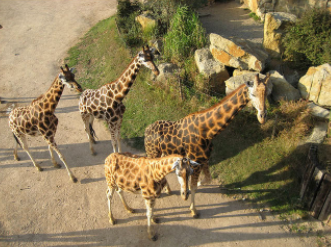

In [30]:
from IPython.display import Image,display_png
display_png(Image('png/example.png'))

In [45]:
!python sample.py --image="png/example.png"

<start> a group of giraffes standing next to each other . <end>


C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


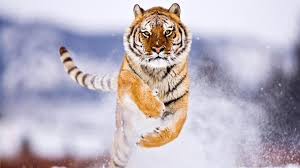

In [46]:
from PIL import Image
Image.open('png/example2.png')

In [56]:
!python sample.py --image="png/example2.png"

<start> a close up of a cat on a rock <end>


C:\Users\user\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Problem 3] Investigate what to do if you want to move with Keras

You can use pytorch2keras converter that has been already built,
these are the steps provided in its readme
https://github.com/gmalivenko/pytorch2keras

1. You can convert by passing your model to pytorch_to_keras
2. It will return a keras model that you can save as an h5 file and then convert it with tensorflowjs_converter but it doesn't work sometimes. As alternative, you may get Tensorflow Graph and save it as a frozen model.
3. You will see the output layer name, so, now it's time to convert my_model.pb to tfjs model